In [2]:
import Pkg
Pkg.activate("../..")

  Activating project at `/global/u2/r/raye/julia-hpc-tutorial-juliacon25`


In [3]:
Pkg.add([
    "CUDA",
    "KernelAbstractions",
    "Atomix",
    "AcceleratedKernels",
    "BenchmarkTools",
    "Adapt",
    "NVTX",
    "ImageShow",
])

   Resolving package versions...
   Installed Polyester ────────── v0.7.18
   Installed Unrolled ─────────── v0.1.5
   Installed ThreadingUtilities ─ v0.5.5
   Installed StrideArraysCore ─── v0.5.7
   Installed ArrayInterface ───── v7.19.0
   Installed AcceleratedKernels ─ v0.3.1
    Updating `/global/u2/r/raye/julia-hpc-tutorial-juliacon25/Project.toml`
⌃ [6a4ca0a5] + AcceleratedKernels v0.3.1
 [79e6a3ab] + Adapt v4.3.0
⌅ [a9b6321e] + Atomix v0.1.0
  [4e3cecfd] + ImageShow v0.3.8
  [5da4648a] + NVTX v1.0.0
    Updating `/global/u2/r/raye/julia-hpc-tutorial-juliacon25/Manifest.toml`
 [6a4ca0a5] + AcceleratedKernels v0.3.1
  [dce04be8] + ArgCheck v2.5.0
  [4fba245c] + ArrayInterface v7.19.0
  [62783981] + BitTwiddlingConvenienceFunctions v0.1.6
  [2a0fbf3d] + CPUSummary v0.2.6
  [fb6a15b2] + CloseOpenIntervals v0.1.13
  [f70d9fcc] + CommonWorldInvalidations v1.0.0
  [adafc99b] + CpuId v0.3.1
  [615f187c] + IfElse v0.1.1
  [4e3cecfd] + ImageShow v0.3.8
  [10f19ff3] + LayoutPointers v0.1.

In [4]:
versioninfo()

Julia Version 1.11.4
Commit 8561cc3d68d (2025-03-10 11:36 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 128 × AMD EPYC 7763 64-Core Processor
  WORD_SIZE: 64
  LLVM: libLLVM-16.0.6 (ORCJIT, znver3)
Threads: 16 default, 0 interactive, 8 GC (on 128 virtual cores)
Environment:
  LD_LIBRARY_PATH = /global/common/software/nersc9/darshan/default/lib:/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/math_libs/12.4/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/extras/CUPTI/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/extras/Debugger/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/nvvm/lib64:/opt/nvidia/hpc_sdk/Linux_x86_64/24.5/cuda/12.4/lib64:/opt/cray/pe/papi/7.1.0.2/lib64:/opt/cray/libfabric/1.20.1/lib64:/opt/cray/libfabric/default/lib64
  JULIA_LOAD_PATH = :/global/common/software/nersc9/julia/environments/gnu.cray-mpich.cuda12.4
  JULIA_SSL_CA_ROOTS_PATH = /etc/ssl/ca-bundle.pem
  JULIA_NUM_THREADS = 16
  JULIA_R

In [5]:
using CUDA, KernelAbstractions, Adapt

[ Info: Precompiling ParsersExt [f526588d-e68b-5dc5-a62e-ff9f36e48b1a] (cache misses: wrong dep version loaded (4))


## A first GPU kernel

In [6]:
function copy_cpu!(A, B)
  for I in 1:length(A)
    @inbounds A[I] = B[I]
  end
end

copy_cpu! (generic function with 1 method)

In [7]:
@kernel function copy_kernel!(A, B)
  I = @index(Global)
  @inbounds A[I] = B[I]
end

copy_kernel! (generic function with 4 methods)

In [8]:
function copy_ka!(A, B)
  backend = get_backend(A)
  @assert size(A) == size(B)
  @assert get_backend(B) == backend

  kernel = copy_kernel!(backend)
  kernel(A, B, ndrange = length(A))
  return
end

copy_ka! (generic function with 1 method)

In [9]:
using CUDA: i32

In [10]:
function copy_kernel_cuda!(A, B)
  I = (blockIdx().x-1i32) * blockDim().x + threadIdx().x
  if I <= length(A)
      @inbounds A[I] = B[I]
  end
  return nothing
end

copy_kernel_cuda! (generic function with 1 method)

In [11]:
function copy_cuda!(A, B)
  kernel = @cuda launch=false copy_kernel_cuda!(A, B)
  config = launch_configuration(kernel.fun)
  threads = min(length(A), config.threads)
  blocks = cld(length(A), threads)

  kernel(A, B; threads, blocks)
end

copy_cuda! (generic function with 1 method)

In [12]:
B = rand(64_000);

In [13]:
let
  A = similar(B)
  copy_cpu!(A, B)
  @assert A == B
end

Julia GPU ecosystem follows the motto: Compute follows Data

So let's move our data to the GPU!

In [14]:
d_B = adapt(CuArray, B);

In [15]:
typeof(d_B)

CuArray{Float64, 1, CUDA.DeviceMemory}

In [16]:
let
  d_A = similar(d_B)
  copy_cuda!(d_A, d_B)
  @assert d_A == d_B
end

Note that Julia GPU Ecosystem, synchronizes the GPU on access. So we are launchign two GPU kernels here, first the copy, then the comparision and they are both executing asynchronously, but ordered with respect to each other.

We then "wait" for the result of the comparision.

In [17]:
using BenchmarkTools

[ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf] (cache misses: wrong dep version loaded (4))


In [18]:
@benchmark copy_cuda!(d_A, $d_B) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 7 evaluations per sample.
 Range (min … max):  4.164 μs …  12.606 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.921 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   5.021 μs ± 802.313 ns  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▅█▆▂  ▁▆▆▃▁▇▇▄▂   ▂▆▅▅▅▃▂     ▃▄▃                           ▂
  ████▇▅██████████▅▃███████▇▇▇▆█████▇▇▇▆▇▇▇███▄▅▇▆▆▄▆▅▅▃▆▅▅▅▅ █
  4.16 μs      Histogram: log(frequency) by time      8.03 μs <

 Memory estimate: 400 bytes, allocs estimate: 22.

In [19]:
CUDA.@profile let
  d_A = similar(d_B)
  for _ in 1:10
    copy_cuda!(d_A, d_B)
  end
end

Profiler ran for 242.23 µs, capturing 261 events.

Host-side activity: calling CUDA APIs took 122.55 µs (50.59% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│   33.27% │   80.59 µs │    10 │   8.06 µs ± 10.45  (  2.86 ‥ 37.19) │ cuLaunchKernel          │
│    4.04% │    9.78 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴─────────────────────────┘

Device-side activity: GPU was busy for 27.89 µs (11.52% of the trace)
┌──────────┬────────────┬───────┬────────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution             

So there seems to be a discrepancy between the measurement of `@benchmark` and `CUDA.@profile`, `@benchmark` seems to vastly over-estimate the performance of the GPU code. To remedy this we need to include a synchronization operation with benchmarking.

In [20]:
@benchmark CUDA.@sync(copy_cuda!(d_A, $d_B)) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  14.428 μs … 82.189 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     16.251 μs              ┊ GC (median):    0.00%
 Time  (mean ± σ):   17.593 μs ±  3.389 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁▅█▄▃▁▂                                                    
  ▁▄███████▇▅▃▂▂▂▂▂▁▂▁▂▂▄▅▄▄▃▂▂▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  14.4 μs         Histogram: frequency by time        28.5 μs <

 Memory estimate: 400 bytes, allocs estimate: 22.

With KernelAbstractions we can now write code that is portable and can be used both for data that resides on the CPU as well as the GPU, therefore implementing the "Compute follows Data" paradigm.

In [21]:
let
  A = similar(B)
  copy_ka!(A, B)
  @assert A == B
end

In [22]:
let
  d_A = similar(d_B)
  copy_ka!(d_A, d_B)
  @assert d_A == d_B
end

In [23]:
@benchmark copy_ka!(A, $B) setup=(A = similar(B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  35.620 μs … 231.688 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     56.639 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   57.426 μs ±   8.591 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

                    ▃▆▇█▇█▇▆▇▃▂▁▁                               
  ▁▁▂▂▂▃▃▃▃▃▂▂▂▂▂▂▄▇█████████████▇▆▄▄▃▃▂▂▂▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁ ▃
  35.6 μs         Histogram: frequency by time         87.9 μs <

 Memory estimate: 11.16 KiB, allocs estimate: 160.

In [24]:
@benchmark CUDA.@sync(copy_ka!(d_A, $d_B)) setup=(d_A = similar(d_B))

BenchmarkTools.Trial: 10000 samples with 1 evaluation per sample.
 Range (min … max):  17.263 μs … 111.165 μs  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     19.838 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   21.397 μs ±   3.962 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▆█▆▃▂▄▂                                                    
  ▁▃▆████████▅▄▂▂▂▂▂▂▃▅▇▆▄▃▂▃▅▅▄▃▂▂▂▁▁▂▂▂▂▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁ ▃
  17.3 μs         Histogram: frequency by time         34.3 μs <

 Memory estimate: 1.31 KiB, allocs estimate: 54.

In [25]:
CUDA.@profile let
  d_A = similar(d_B)
  for _ in 1:10
    copy_ka!(d_A, d_B)
  end
end

Profiler ran for 244.86 µs, capturing 261 events.

Host-side activity: calling CUDA APIs took 96.56 µs (39.44% of the trace)
┌──────────┬────────────┬───────┬─────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                   │ Name                    │
├──────────┼────────────┼───────┼─────────────────────────────────────┼─────────────────────────┤
│   25.80% │   63.18 µs │    10 │   6.32 µs ± 8.95   (  2.86 ‥ 31.71) │ cuLaunchKernel          │
│    4.97% │   12.16 µs │     1 │                                     │ cuMemAllocFromPoolAsync │
└──────────┴────────────┴───────┴─────────────────────────────────────┴─────────────────────────┘

Device-side activity: GPU was busy for 28.61 µs (11.68% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────┬───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

We can see that KernelAbstractions is a bit slower than pure CUDA, and that is partially expected due to some convenience functionality.

## A more compilcated kernel -- transpose

In [45]:
const nreps = 3
const N = 2048
const T = Float32

const TILE_DIM = 32
const BLOCK_ROWS = 8

8

### Naive kernels

In [47]:
@kernel function simple_copy_kernel!(output, @Const(input))
    I, J = @index(Global, NTuple)
    @inbounds output[I, J] = input[I, J]
end

simple_copy_kernel! (generic function with 4 methods)

In [48]:
@kernel function simple_transpose_kernel!(output, @Const(input))
    I, J = @index(Global, NTuple)
    @inbounds output[J, I] = input[I, J]
end

simple_transpose_kernel! (generic function with 4 methods)

### Using localmemory

In [49]:
@kernel inbounds = true function lmem_copy_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    I, J = @index(Global, NTuple)
    i, j = @index(Local, NTuple)

    N = @uniform @groupsize()[1]
    M = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (N + BANK, M)

    @inbounds tile[i, j] = input[I, J]

    @synchronize

    @inbounds output[I, J] = tile[i, j]
end

lmem_copy_kernel! (generic function with 4 methods)

In [50]:
@kernel inbounds = false function lmem_transpose_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    N = @uniform @groupsize()[1]
    M = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (N + BANK, M)

    # Manually calculate global indexes
    # Later on we need to pivot the group index
    I = (gi - 1) * N + i
    J = (gj - 1) * M + j

    @inbounds tile[i, j] = input[I, J]

    @synchronize

    # Pivot the group index
    I = (gj - 1) * M + i
    J = (gi - 1) * N + j

    @inbounds output[I, J] = tile[j, i]
end

### Local Memory + process multiple elements per lane

In [51]:
using KernelAbstractions.Extras: @unroll

In [52]:
@kernel inbounds=false function coalesced_copy_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]
    BLOCK_ROWS = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # Can't use @index(Global), because we use a smaller ndrange
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds tile[i, j + k] = input[I, J + k]
    end

    @synchronize

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds output[I, J + k] = tile[i, j + k]
    end
end

In [53]:
@kernel inbounds = false function coalesced_transpose_kernel!(
        output, @Const(input),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]
    BLOCK_ROWS = @uniform @groupsize()[2]

    # +1 to avoid bank conflicts on shared memory
    tile = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # Can't use @index(Global), because we use a smaller ndrange
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds tile[i, j + k] = input[I, J + k]
    end

    @synchronize

    # Transpose block offsets
    I = (gj - 1) * TILE_DIM + i
    J = (gi - 1) * TILE_DIM + j

    @unroll for k in 0:BLOCK_ROWS:(TILE_DIM - 1)
        @inbounds output[I, J + k] = tile[j + k, i]
    end
end

### Benchmark harness

In [54]:
using NVTX, Random

In [55]:
backend = CUDABackend()

CUDABackend(false, false)

In [56]:
CUDA.@profile for block_dims in ((TILE_DIM, TILE_DIM), (TILE_DIM * TILE_DIM, 1), (1, TILE_DIM * TILE_DIM))
    for (name, kernel) in (
            ("copy", simple_copy_kernel!(backend, block_dims)),
            ("transpose", simple_transpose_kernel!(backend, block_dims)),
        )
        NVTX.@range "Simple $name $block_dims" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # compile kernel
            kernel(output, input, ndrange = size(output))
            for rep in 1:nreps
                kernel(output, input, ndrange = size(output))
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 2.83 s, capturing 5071 events.

Host-side activity: calling CUDA APIs took 75.82 ms (2.68% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│    2.05% │   57.88 ms │     7 │   8.27 ms ± 14.28  (  0.01 ‥ 32.83)   │ cudaLaunchKernel        │
│    0.05% │    1.54 ms │     1 │                                       │ cudaMalloc              │
│    0.03% │  952.24 µs │     6 │ 158.71 µs ± 47.11  (130.89 ‥ 252.49)  │ cuModuleLoadDataEx      │
│    0.03% │  729.32 µs │    12 │  60.78 µs ± 76.82  (  2.15 ‥ 166.42)  │ cuMemAllocFromPoolAsync │
│    0.01% │  251.77 µs │     1 │                                       │ cudaDeviceSynchronize   │
│    0.01% │  236.27 µs │    24 │   9.84 µs ± 9.42   (   3.1 ‥ 29.8)    │ cuLa

In [57]:
# Benchmark localmem
CUDA.@profile for (name, kernel) in (
        ("copy", lmem_copy_kernel!(backend, (TILE_DIM, TILE_DIM))),
        ("transpose", lmem_transpose_kernel!(backend, (TILE_DIM, TILE_DIM))),
    )
    for bank in (true, false)
        NVTX.@range "Localmem $name ($TILE_DIM, $TILE_DIM) bank=$bank" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # compile kernel
            kernel(output, input, Val(Int(bank)), ndrange = size(output))
            for rep in 1:nreps
                kernel(output, input, Val(Int(bank)), ndrange = size(output))
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 997.04 ms, capturing 1846 events.

Host-side activity: calling CUDA APIs took 1.43 ms (0.14% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│    0.06% │  602.25 µs │     4 │ 150.56 µs ± 9.64   (138.28 ‥ 160.46)  │ cuModuleLoadDataEx      │
│    0.02% │  179.29 µs │    16 │  11.21 µs ± 12.32  (   3.1 ‥ 38.86)   │ cuLaunchKernel          │
│    0.01% │  132.08 µs │     4 │  33.02 µs ± 7.9    ( 24.32 ‥ 42.2)    │ cuModuleGetFunction     │
│    0.01% │   67.71 µs │     8 │   8.46 µs ± 4.11   (  2.86 ‥ 15.97)   │ cuMemAllocFromPoolAsync │
│    0.01% │   53.41 µs │     4 │  13.35 µs ± 7.51   (  7.39 ‥ 24.08)   │ cudaLaunchKernel        │
│    0.00% │   41.48 µs │     4 │  10.37 µs ± 0.74   (   9.3 ‥ 10.97)   │ cu

In [58]:
# Benchmark localmem + multiple elements per lane
CUDA.@profile for (name, kernel) in (
        ("copy", coalesced_copy_kernel!(backend, (TILE_DIM, BLOCK_ROWS))),
        ("transpose", coalesced_transpose_kernel!(backend, (TILE_DIM, BLOCK_ROWS))),
    )
    for bank in (true, false)
        NVTX.@range "Localmem + multiple elements $name ($TILE_DIM, $BLOCK_ROWS) bank=$bank" let
            input = rand!(allocate(backend, T, N, N))
            output = similar(input)

            # We want a number of blocks equivalent to (TILE_DIM, TILE_DIM)
            # but our blocks are (TILE_DIM, BLOCK_ROWS) so we need to remove
            # a factor from the size of the array otherwise we get to many blocks
            block_factor = div(TILE_DIM, BLOCK_ROWS)
            ndrange = (N, div(N, block_factor))

            # compile kernel
            kernel(output, input, Val(Int(bank)), ndrange = ndrange)
            for rep in 1:nreps
                kernel(output, input, Val(Int(bank)), ndrange = ndrange)
            end
            KernelAbstractions.synchronize(backend)
        end
    end
end

Profiler ran for 1.09 s, capturing 1210 events.

Host-side activity: calling CUDA APIs took 1.31 ms (0.12% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬─────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                    │
├──────────┼────────────┼───────┼───────────────────────────────────────┼─────────────────────────┤
│    0.05% │  575.78 µs │     4 │ 143.95 µs ± 15.69  (130.18 ‥ 166.42)  │ cuModuleLoadDataEx      │
│    0.02% │  172.38 µs │    16 │  10.77 µs ± 10.2   (   3.1 ‥ 28.85)   │ cuLaunchKernel          │
│    0.01% │  118.73 µs │     4 │  29.68 µs ± 3.08   ( 25.27 ‥ 32.42)   │ cuModuleGetFunction     │
│    0.01% │   82.02 µs │     4 │   20.5 µs ± 18.11  (  8.34 ‥ 47.45)   │ cudaLaunchKernel        │
│    0.01% │   57.46 µs │     8 │   7.18 µs ± 4.66   (  2.86 ‥ 14.31)   │ cuMemAllocFromPoolAsync │
│    0.00% │   48.88 µs │     4 │  12.22 µs ± 5.06   (   9.3 ‥ 19.79)   │ cuCtx

## Atomic operations

In [59]:
@kernel function racy_kernel!(out, arr)
	i, j = @index(Global, NTuple)
	for k in 1:size(out, 1)
		out[k, i] += arr[i, j]
	end
end

racy_kernel! (generic function with 4 methods)

In [60]:
using ImageShow

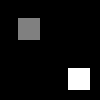

In [61]:
img = zeros(Float32, (50, 50));
img[10:20, 10:20] .= 1;
img[35:45, 35:45] .= 2;
simshow(img)

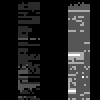

In [62]:
out = KernelAbstractions.zeros(backend, Float32, size(img));
racy_kernel!(backend)(out, adapt(backend, img), ndrange=size(img))
simshow(Array(out))

In [63]:
using Atomix: @atomic, @atomicswap, @atomicreplace

In [64]:
@kernel function nonracy_kernel!(out, arr)
	i, j = @index(Global, NTuple)
	for k in 1:size(out, 1)
		@atomic out[k, i] += arr[i, j]
	end
end

nonracy_kernel! (generic function with 4 methods)

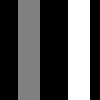

In [65]:
out = KernelAbstractions.zeros(backend, Float32, size(img));
nonracy_kernel!(backend)(out, adapt(backend, img), ndrange=size(img))
simshow(Array(out))

## Matrix multiply

In [66]:
@kernel function naive_matmul_kernel!(output, a, b)
    i, j = @index(Global, NTuple)

    # creating a temporary sum variable for matrix multiplication
    tmp_sum = zero(eltype(output))
    for k in 1:size(a)[2]
        tmp_sum += a[i, k] * b[k, j]
    end

    output[i, j] = tmp_sum
end

naive_matmul_kernel! (generic function with 4 methods)

In [67]:
# Creating a wrapper kernel for launching with error checks
function naive_matmul!(output, a, b)
    if size(a)[2] != size(b)[1]
        println("Matrix size mismatch!")
        return nothing
    end
    backend = KernelAbstractions.get_backend(a)
    kernel! = naive_matmul_kernel!(backend)
    kernel!(output, a, b, ndrange = size(output))
    return
end

naive_matmul! (generic function with 1 method)

In [68]:
let
  a = rand!(allocate(backend, Float32, 256, 123))
  b = rand!(allocate(backend, Float32, 123, 45))
  output = KernelAbstractions.zeros(backend, Float32, 256, 45)

  naive_matmul!(output, a, b)

  @assert isapprox(output, a * b)
end

In [81]:
@kernel inbounds = false function coalesced_matmul_kernel!(
        output, @Const(A), @Const(B),
        ::Val{BANK} = Val(1),
    ) where {BANK}
    gi, gj = @index(Group, NTuple)
    i, j = @index(Local, NTuple)

    TILE_DIM = @uniform @groupsize()[1]

    # +1 to avoid bank conflicts on shared memory
    tile1 = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)
    tile2 = @localmem eltype(output) (TILE_DIM + BANK, TILE_DIM)

    # private variable for tile output
    outval = @private eltype(output) 1
    @inbounds outval[1] = -zero(eltype(output))

    @uniform N = size(output, 1)
    @uniform M = size(output, 2)
    @uniform R = size(A, 2)
    # number of tiles depends on inner dimension
    @uniform NUM_TILES = div(R + TILE_DIM - 1, TILE_DIM)

    # loop over all tiles needed for this calculation
    for t in 0:(NUM_TILES - 1)
        # Can't use @index(Global), because we use a smaller ndrange
        I = (gi - 1) * TILE_DIM + i
        J = (gj - 1) * TILE_DIM + j

        # load inputs into tiles, with bounds checking for non-square matrices
        if I <= N && t * TILE_DIM + j <= R
            @inbounds tile1[i, j] = A[I, t * TILE_DIM + j]
        else
            @inbounds tile1[i, j] = 0.0
        end
        if t * TILE_DIM + i <= R && J <= M
            @inbounds tile2[i, j] = B[t * TILE_DIM + i, J]
        else
            @inbounds tile2[i, j] = 0.0
        end

        # wait for all tiles to be loaded
        @synchronize

        # get global values again
        I = (gi - 1) * TILE_DIM + i
        J = (gj - 1) * TILE_DIM + j

        # calculate value of spot in output, use temporary value to allow for vectorization
        out = zero(eltype(output))
        @simd for k in 1:TILE_DIM
            @inbounds out += tile1[i, k] * tile2[k, j]
        end
        outval[1] += out

        @synchronize
    end

    # get global indices again
    I = (gi - 1) * TILE_DIM + i
    J = (gj - 1) * TILE_DIM + j

    # save if inbounds
    if I <= N && J <= M
        @inbounds output[I, J] = outval[1]
    end
end

In [70]:
# Creating a wrapper kernel for launching with error checks
function coalesced_matmul!(output, a, b)
    if size(a)[2] != size(b)[1]
        println("Matrix size mismatch!")
        return nothing
    end
    backend = KernelAbstractions.get_backend(a)
    kernel! = coalesced_matmul_kernel!(backend, (TILE_DIM, TILE_DIM))
    kernel!(output, a, b, ndrange = size(output))
    return
end

coalesced_matmul! (generic function with 1 method)

In [78]:
let
  a = rand!(allocate(backend, Float32, 32, 123))
  b = rand!(allocate(backend, Float32, 123, 32))
  output = KernelAbstractions.zeros(backend, Float32, 32, 32)

  coalesced_matmul!(output, a, b)
  @assert isapprox(output, a * b)
end

In [79]:
import LinearAlgebra

### Exercise
- Vary N, R, M
- Vary T

In [84]:
let
    N = 1024
    R = 512
    M = 2048
    T = Float64
    A = rand!(allocate(backend, T, N, R))
    B = rand!(allocate(backend, T, R, M))
    output_naive = KernelAbstractions.zeros(backend, T, N, M)
    output_coalesced = KernelAbstractions.zeros(backend, T, N, M)
    output_mul = KernelAbstractions.zeros(backend, T, N, M)


    CUDA.@profile for _ in 1:nreps
      NVTX.@range "Naive Matmul" begin
          naive_matmul!(output_naive, A, B)
          KernelAbstractions.synchronize(backend)
      end

      NVTX.@range "Coalesced Matmul" begin
          coalesced_matmul!(output_coalesced, A, B)
          KernelAbstractions.synchronize(backend)
      end

      NVTX.@range "LinearAlgebra.mul!" begin
          LinearAlgebra.mul!(output_mul, A, B)
          KernelAbstractions.synchronize(backend)
      end
    end
end

Profiler ran for 13.09 ms, capturing 6395 events.

Host-side activity: calling CUDA APIs took 4.17 ms (31.90% of the trace)
┌──────────┬────────────┬───────┬───────────────────────────────────────┬──────────────────────────────────────────────────────┐
│ Time (%) │ Total time │ Calls │ Time distribution                     │ Name                                                 │
├──────────┼────────────┼───────┼───────────────────────────────────────┼──────────────────────────────────────────────────────┤
│   67.42% │    8.82 ms │     9 │ 980.24 µs ± 902.35 (  1.19 ‥ 2095.46) │ cuStreamSynchronize                                  │
│    0.67% │   87.26 µs │     9 │    9.7 µs ± 6.11   (  4.53 ‥ 25.03)   │ cuLaunchKernel                                       │
│    0.38% │   49.35 µs │    48 │   1.03 µs ± 1.5    (  0.24 ‥ 8.58)    │ cuKernelGetFunction                                  │
│    0.26% │   34.57 µs │     6 │   5.76 µs ± 3.97   (  1.91 ‥ 10.97)   │ cuMemAllocFromPoolAsync     